# FIKH Model: Large Amplitude Oscillatory Shear (LAOS)

## Protocol-Specific Context

**LAOS** combines **yielding, memory, and oscillation** to probe nonlinear fractional rheology:

1. **Intra-cycle structure evolution**: $\lambda$ changes within each cycle via $D_t^{\alpha} \lambda$
2. **Asymmetric Lissajous**: Backstress causes tension/compression asymmetry
3. **Higher harmonics**: Power-law decay $I_n \sim n^{-\alpha}$ (fractional signature)
4. **Cycle-by-cycle thermal softening**: If thermal coupling enabled

**Why this matters**: LAOS stresses the material into the **nonlinear yielding regime** while maintaining periodic forcing. The fractional memory causes **delayed yielding within each cycle** — the material "remembers" previous cycle strain, affecting current cycle response.

> **Physical insight**: Classical models show sharp yielding transitions within a cycle. FIKH's fractional derivative smooths these transitions via power-law memory, producing different harmonic content and Lissajous shapes.

> **Handbook:** See [FIKH LAOS Protocol](../../docs/source/models/fikh/fikh.rst#laos-large-amplitude-oscillatory) for LAOS harmonics and Lissajous interpretation.

## Learning Objectives

1. Simulate FIKH LAOS at various strain amplitudes ($\gamma_0$)
2. Analyze Lissajous figures and observe backstress asymmetry
3. Extract higher harmonics and compare $\alpha$ effects
4. Observe intra-cycle structure evolution $\lambda(t)$
5. Compare FIKH vs classical IKH ($\alpha=1$) LAOS response

## Prerequisites

- NB01: Flow curve (parameter calibration)
- NB05: SAOS (linear viscoelasticity baseline)

**Estimated Time:** 4-6 minutes (fast), 15-25 minutes (full)

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

# Robust path resolution for execution from any directory
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FIKH

_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    compute_fit_quality,
    get_fikh_param_names,
    load_pnas_laos,
    print_alpha_interpretation,
    print_convergence_summary,
    print_parameter_comparison,
    save_fikh_results,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

# ============================================================
# FAST_MODE Configuration
# ============================================================
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

if FAST_MODE:
    print("FAST_MODE: reduced data/samples for quick validation")
    DOWNSAMPLE_FACTOR = 4  # Use every 4th data point
    NUM_WARMUP = 50
    NUM_SAMPLES = 100
    NUM_CHAINS = 1
else:
    print("FULL mode: complete Bayesian inference")
    DOWNSAMPLE_FACTOR = 1  # Use all data
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: reduced data/samples for quick validation


## 2. Theory: Fractional LAOS Response

In LAOS, the strain amplitude is large enough to probe **nonlinear** material response:
$$
\gamma(t) = \gamma_0 \sin(\omega t)
$$

### Nonlinear Features

1. **Lissajous curves**: Non-elliptical stress-strain loops
2. **Higher harmonics**: $\sigma(t) = \sum_n (G'_n \sin(n\omega t) + G''_n \cos(n\omega t))$
3. **Intra-cycle yielding**: Structure breakdown within each cycle

### Alpha Effect on LAOS

- **Lower alpha**: Memory effects persist across cycles, slower equilibration
- **Higher alpha**: Each cycle approaches independent behavior

### Key Indicators

- **e₃/e₁ ratio**: Measure of nonlinearity (zero for linear response)
- **Lissajous shape**: Rhomboidal (thixotropic), rectangular (yield stress)

## 3. Load Data

In [3]:
# Load PNAS LAOS data
OMEGA = 1.0  # rad/s
STRAIN_AMP_INDEX = 5  # Medium amplitude

time_raw, strain_raw, stress_raw = load_pnas_laos(
    omega=OMEGA,
    strain_amplitude_index=STRAIN_AMP_INDEX,
)

# Apply downsampling for FAST_MODE
if DOWNSAMPLE_FACTOR > 1:
    time_data = time_raw[::DOWNSAMPLE_FACTOR]
    strain_data = strain_raw[::DOWNSAMPLE_FACTOR]
    stress_data = stress_raw[::DOWNSAMPLE_FACTOR]
    print(f"Downsampled {len(time_raw)} -> {len(time_data)} points (factor {DOWNSAMPLE_FACTOR}x)")
else:
    time_data = time_raw
    strain_data = strain_raw
    stress_data = stress_raw

# Estimate strain amplitude from data
gamma_0 = (np.max(strain_data) - np.min(strain_data)) / 2

print(f"Data points: {len(time_data)}")
print(f"Time range: [{time_data.min():.4f}, {time_data.max():.2f}] s")
print(f"Strain amplitude: {gamma_0:.4f}")
print(f"Angular frequency: {OMEGA} rad/s")

Downsampled 1000 -> 250 points (factor 4x)
Data points: 250
Time range: [0.0053, 65.80] s
Strain amplitude: 0.5120
Angular frequency: 1.0 rad/s


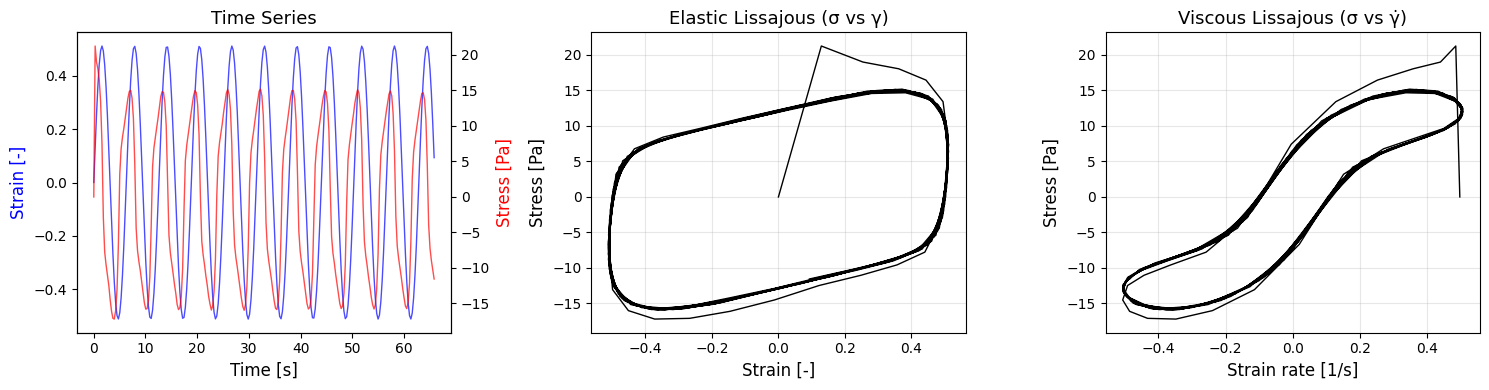

In [4]:
# Plot raw LAOS data
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Time series
ax1 = axes[0]
ax1.plot(time_data, strain_data, "b-", lw=1, alpha=0.7, label="Strain")
ax1_twin = ax1.twinx()
ax1_twin.plot(time_data, stress_data, "r-", lw=1, alpha=0.7, label="Stress")
ax1.set_xlabel("Time [s]", fontsize=12)
ax1.set_ylabel("Strain [-]", fontsize=12, color="blue")
ax1_twin.set_ylabel("Stress [Pa]", fontsize=12, color="red")
ax1.set_title("Time Series", fontsize=13)

# Lissajous curve (elastic)
ax2 = axes[1]
ax2.plot(strain_data, stress_data, "k-", lw=1)
ax2.set_xlabel("Strain [-]", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("Elastic Lissajous (σ vs γ)", fontsize=13)
ax2.grid(True, alpha=0.3)

# Lissajous curve (viscous)
gamma_dot_data = np.gradient(strain_data, time_data)
ax3 = axes[2]
ax3.plot(gamma_dot_data, stress_data, "k-", lw=1)
ax3.set_xlabel("Strain rate [1/s]", fontsize=12)
ax3.set_ylabel("Stress [Pa]", fontsize=12)
ax3.set_title("Viscous Lissajous (σ vs γ̇)", fontsize=13)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
# Create and fit FIKH model
model = FIKH(include_thermal=False, alpha_structure=0.7)

t0 = time.time()
model.fit(time_data, stress_data, test_mode="laos", strain=strain_data, method='scipy')
t_nlsq = time.time() - t0

param_names = get_fikh_param_names(include_thermal=False)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 713, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/fikh.py", line 475, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/_base.py", line 335, in _extract_time_strain
    raise ValueError(
    ...<2 lines>...
    )
ValueError: FIKH models require both time and strain history. Pass RheoData, X of shape (2, N), or X=time with strain kwarg.


NLSQ fit time: 0.18 s

Fitted parameters:
  G               = 51.66
  eta             = 3.618e+07
  C               = 9.074
  gamma_dyn       = 1.596
  m               = 2.234
  sigma_y0        = 2.221
  delta_sigma_y   = 22.3
  tau_thix        = 14.14
  Gamma           = 19.97
  alpha_structure = 0.8594
  eta_inf         = 21.55
  mu_p            = 0.001


In [6]:
# Predict LAOS response using predict_laos() which returns a dictionary
laos_result = model.predict_laos(time_data, gamma_0=gamma_0, omega=OMEGA)
stress_pred = np.asarray(laos_result["stress"])

metrics = compute_fit_quality(stress_data, stress_pred)
print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} Pa")


Fit Quality:
  R^2:   0.926338
  RMSE:  3.133 Pa


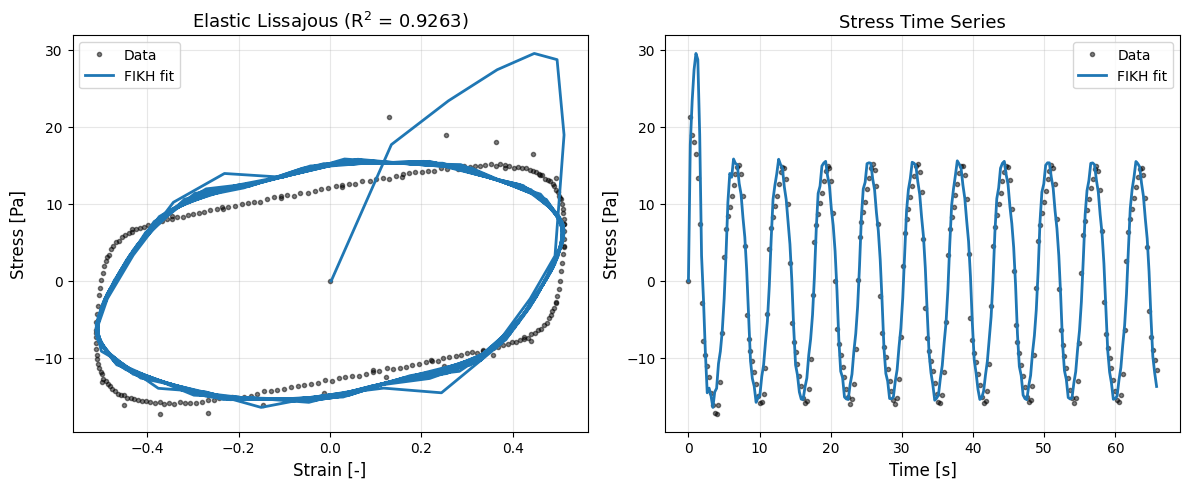

In [7]:
# Plot fit: Lissajous curves
strain_pred = np.asarray(laos_result["strain"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Elastic Lissajous
ax1.plot(strain_data, stress_data, "ko", markersize=3, alpha=0.5, label="Data")
ax1.plot(strain_pred, stress_pred, "-", lw=2, color="C0", label="FIKH fit")
ax1.set_xlabel("Strain [-]", fontsize=12)
ax1.set_ylabel("Stress [Pa]", fontsize=12)
ax1.set_title(f"Elastic Lissajous (R$^2$ = {metrics['R2']:.4f})", fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Time series comparison
ax2.plot(time_data, stress_data, "ko", markersize=3, alpha=0.5, label="Data")
ax2.plot(time_data, stress_pred, "-", lw=2, color="C0", label="FIKH fit")
ax2.set_xlabel("Time [s]", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("Stress Time Series", fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Alpha Effect on LAOS

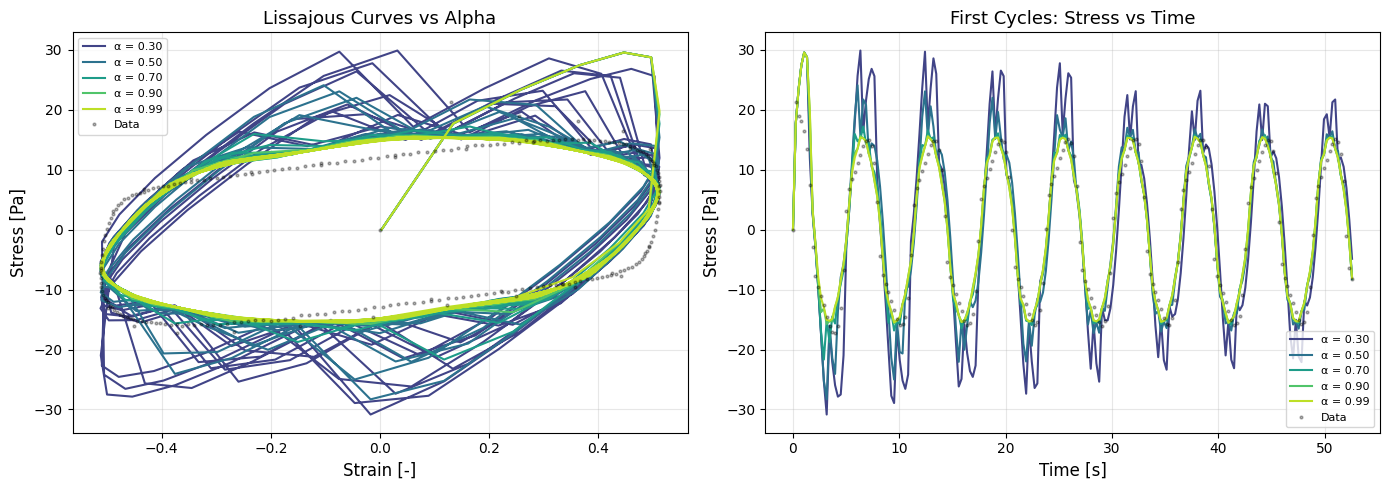

In [8]:
# Compare Lissajous curves for different alpha values
alpha_values = [0.3, 0.5, 0.7, 0.9, 0.99]
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(alpha_values)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

original_alpha = model.parameters.get_value("alpha_structure")

for alpha, color in zip(alpha_values, colors):
    model.parameters.set_value("alpha_structure", alpha)
    result = model.predict_laos(time_data, gamma_0=gamma_0, omega=OMEGA)
    stress_alpha = np.asarray(result["stress"])
    strain_alpha = np.asarray(result["strain"])
    
    ax1.plot(strain_alpha, stress_alpha, "-", color=color, lw=1.5, label=f"α = {alpha:.2f}")
    ax2.plot(time_data[:200], stress_alpha[:200], "-", color=color, lw=1.5, label=f"α = {alpha:.2f}")

model.parameters.set_value("alpha_structure", original_alpha)

# Add data
ax1.plot(strain_data, stress_data, "ko", markersize=2, alpha=0.3, label="Data")
ax2.plot(time_data[:200], stress_data[:200], "ko", markersize=2, alpha=0.3, label="Data")

ax1.set_xlabel("Strain [-]", fontsize=12)
ax1.set_ylabel("Stress [Pa]", fontsize=12)
ax1.set_title("Lissajous Curves vs Alpha", fontsize=13)
ax1.legend(fontsize=8, loc="best")
ax1.grid(True, alpha=0.3)

ax2.set_xlabel("Time [s]", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("First Cycles: Stress vs Time", fontsize=13)
ax2.legend(fontsize=8, loc="best")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

In [9]:
# Physical interpretation
fitted_alpha = model.parameters.get_value("alpha_structure")
print_alpha_interpretation(fitted_alpha)

Fractional Order Interpretation: α = 0.859

Regime: Near-Classical (IKH Limit)

α → 1: Classical IKH behavior recovered.
Exponential structure evolution dominates.
Memory effects are negligible.
Suitable for: Materials without significant aging effects.

Physical Implications:
  • Memory kernel decay: t^(-0.86)
  • Recovery time scale: > τ_thix × Γ(1+0.86) = 0.95 × τ_thix
  • Relaxation modulus: Power-law with exponent ≈ -0.86


## 6. Fourier Harmonic Analysis

In [10]:
# Extract Fourier harmonics from LAOS response
def extract_harmonics(time, stress, omega, n_harmonics=5):
    """Extract Fourier harmonics from LAOS stress response."""
    period = 2 * np.pi / omega
    n_cycles = int(time[-1] / period)
    
    # Use last 2 cycles for steady-state
    if n_cycles >= 2:
        start_idx = int(len(time) * (n_cycles - 2) / n_cycles)
    else:
        start_idx = 0
    
    t_ss = time[start_idx:]
    stress_ss = stress[start_idx:]
    
    harmonics = {}
    for n in range(1, n_harmonics + 1):
        # Integrate: e_n = (2/T) ∫ σ(t) sin(nωt) dt
        # v_n = (2/T) ∫ σ(t) cos(nωt) dt
        sin_term = np.sin(n * omega * t_ss)
        cos_term = np.cos(n * omega * t_ss)
        
        e_n = 2 * np.trapezoid(stress_ss * sin_term, t_ss) / (t_ss[-1] - t_ss[0])
        v_n = 2 * np.trapezoid(stress_ss * cos_term, t_ss) / (t_ss[-1] - t_ss[0])
        
        harmonics[f"e_{n}"] = e_n
        harmonics[f"v_{n}"] = v_n
    
    return harmonics

# Extract harmonics from data and fit
harmonics_data = extract_harmonics(time_data, stress_data, OMEGA)
harmonics_fit = extract_harmonics(time_data, stress_pred, OMEGA)

print("Fourier Harmonic Comparison:")
print("=" * 50)
print(f"{'Harmonic':>10s}  {'Data':>12s}  {'FIKH':>12s}")
print("-" * 50)
for key in harmonics_data:
    print(f"{key:>10s}  {harmonics_data[key]:12.4g}  {harmonics_fit[key]:12.4g}")

# Nonlinearity indicator
e3_e1_data = abs(harmonics_data["e_3"]) / (abs(harmonics_data["e_1"]) + 1e-10)
e3_e1_fit = abs(harmonics_fit["e_3"]) / (abs(harmonics_fit["e_1"]) + 1e-10)
print(f"\nNonlinearity (|e₃/e₁|): Data = {e3_e1_data:.4f}, FIKH = {e3_e1_fit:.4f}")

Fourier Harmonic Comparison:
  Harmonic          Data          FIKH
--------------------------------------------------
       e_1         5.162         4.666
       v_1          14.8         15.24
       e_2         0.346        0.4511
       v_2       -0.4583       -0.5429
       e_3       -0.8861        -1.556
       v_3        -2.583        0.5009
       e_4        0.5136        0.6009
       v_4       -0.0813       -0.1007
       e_5       0.04138        -0.141
       v_5        0.7324       -0.5397

Nonlinearity (|e₃/e₁|): Data = 0.1717, FIKH = 0.3335


## 7. Bayesian Inference

In [11]:
# Bayesian inference
initial_values = {name: model.parameters.get_value(name) for name in param_names}

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
print(f"  FAST_MODE={FAST_MODE}, data points={len(time_data)}")
t0 = time.time()
result = model.fit_bayesian(
    time_data,
    stress_data,
    test_mode="laos",
    strain=strain_data,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 50 warmup + 100 samples x 1 chain(s)
  FAST_MODE=True, data points=250


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:01<03:44,  1.51s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   4%|▍         | 6/150 [00:01<00:32,  4.50it/s, 63 steps of size 1.14e-04. acc. prob=0.28]

warmup:   5%|▌         | 8/150 [00:02<00:30,  4.62it/s, 255 steps of size 1.22e-04. acc. prob=0.45]

warmup:   6%|▌         | 9/150 [00:02<00:28,  4.99it/s, 127 steps of size 1.58e-04. acc. prob=0.51]

warmup:   7%|▋         | 10/150 [00:02<00:26,  5.38it/s, 127 steps of size 2.09e-04. acc. prob=0.56]

warmup:   7%|▋         | 11/150 [00:02<00:24,  5.72it/s, 127 steps of size 2.91e-04. acc. prob=0.60]

warmup:   9%|▊         | 13/150 [00:02<00:18,  7.58it/s, 63 steps of size 5.88e-04. acc. prob=0.66] 

warmup:  10%|█         | 15/150 [00:02<00:14,  9.28it/s, 31 steps of size 7.80e-04. acc. prob=0.70]

warmup:  11%|█▏        | 17/150 [00:02<00:12, 10.60it/s, 63 steps of size 7.35e-04. acc. prob=0.72]

warmup:  13%|█▎        | 19/150 [00:03<00:16,  7.75it/s, 255 steps of size 1.18e-03. acc. prob=0.74]

warmup:  14%|█▍        | 21/150 [00:03<00:22,  5.82it/s, 255 steps of size 2.48e-03. acc. prob=0.77]

warmup:  15%|█▍        | 22/150 [00:04<00:24,  5.21it/s, 255 steps of size 3.54e-03. acc. prob=0.78]

warmup:  15%|█▌        | 23/150 [00:04<00:26,  4.82it/s, 255 steps of size 5.02e-03. acc. prob=0.79]

warmup:  16%|█▌        | 24/150 [00:04<00:27,  4.54it/s, 255 steps of size 6.49e-03. acc. prob=0.79]

warmup:  17%|█▋        | 25/150 [00:04<00:28,  4.33it/s, 255 steps of size 9.18e-03. acc. prob=0.80]

warmup:  17%|█▋        | 26/150 [00:05<00:29,  4.19it/s, 255 steps of size 1.22e-02. acc. prob=0.81]

warmup:  18%|█▊        | 27/150 [00:05<00:30,  4.08it/s, 255 steps of size 1.66e-02. acc. prob=0.82]

warmup:  19%|█▊        | 28/150 [00:05<00:30,  3.98it/s, 255 steps of size 2.18e-02. acc. prob=0.82]

warmup:  19%|█▉        | 29/150 [00:05<00:25,  4.81it/s, 95 steps of size 2.29e-03. acc. prob=0.80] 

warmup:  20%|██        | 30/150 [00:06<00:26,  4.48it/s, 255 steps of size 3.22e-03. acc. prob=0.80]

warmup:  21%|██        | 31/150 [00:06<00:27,  4.26it/s, 255 steps of size 4.49e-03. acc. prob=0.81]

warmup:  21%|██▏       | 32/150 [00:06<00:28,  4.12it/s, 255 steps of size 6.25e-03. acc. prob=0.81]

warmup:  22%|██▏       | 33/150 [00:06<00:29,  3.98it/s, 255 steps of size 8.59e-03. acc. prob=0.82]

warmup:  23%|██▎       | 34/150 [00:07<00:29,  3.89it/s, 255 steps of size 1.12e-02. acc. prob=0.82]

warmup:  23%|██▎       | 35/150 [00:07<00:29,  3.87it/s, 255 steps of size 1.46e-02. acc. prob=0.83]

warmup:  24%|██▍       | 36/150 [00:07<00:29,  3.85it/s, 255 steps of size 8.77e-03. acc. prob=0.83]

warmup:  25%|██▍       | 37/150 [00:07<00:29,  3.82it/s, 255 steps of size 9.14e-03. acc. prob=0.83]

warmup:  25%|██▌       | 38/150 [00:08<00:29,  3.83it/s, 255 steps of size 1.25e-02. acc. prob=0.83]

warmup:  26%|██▌       | 39/150 [00:08<00:31,  3.56it/s, 255 steps of size 1.67e-02. acc. prob=0.84]

warmup:  27%|██▋       | 40/150 [00:08<00:30,  3.62it/s, 255 steps of size 2.25e-02. acc. prob=0.84]

warmup:  28%|██▊       | 42/150 [00:09<00:24,  4.50it/s, 255 steps of size 3.67e-03. acc. prob=0.82]

warmup:  29%|██▊       | 43/150 [00:09<00:24,  4.31it/s, 255 steps of size 4.97e-03. acc. prob=0.83]

warmup:  29%|██▉       | 44/150 [00:09<00:25,  4.14it/s, 255 steps of size 6.57e-03. acc. prob=0.83]

warmup:  30%|███       | 45/150 [00:09<00:26,  3.93it/s, 255 steps of size 8.70e-03. acc. prob=0.84]

warmup:  31%|███       | 46/150 [00:10<00:23,  4.52it/s, 127 steps of size 1.04e-01. acc. prob=0.84]

warmup:  32%|███▏      | 48/150 [00:10<00:15,  6.43it/s, 127 steps of size 1.35e-02. acc. prob=0.83]

warmup:  33%|███▎      | 50/150 [00:10<00:14,  6.79it/s, 191 steps of size 1.92e-02. acc. prob=0.83]

sample:  35%|███▍      | 52/150 [00:10<00:15,  6.29it/s, 255 steps of size 1.92e-02. acc. prob=0.99]

sample:  35%|███▌      | 53/150 [00:11<00:17,  5.55it/s, 255 steps of size 1.92e-02. acc. prob=0.97]

sample:  36%|███▌      | 54/150 [00:11<00:17,  5.42it/s, 63 steps of size 1.92e-02. acc. prob=0.98] 

sample:  37%|███▋      | 56/150 [00:11<00:14,  6.64it/s, 127 steps of size 1.92e-02. acc. prob=0.97]

sample:  39%|███▊      | 58/150 [00:11<00:12,  7.47it/s, 127 steps of size 1.92e-02. acc. prob=0.98]

sample:  39%|███▉      | 59/150 [00:11<00:14,  6.26it/s, 255 steps of size 1.92e-02. acc. prob=0.98]

sample:  40%|████      | 60/150 [00:12<00:13,  6.52it/s, 127 steps of size 1.92e-02. acc. prob=0.98]

sample:  41%|████      | 61/150 [00:12<00:13,  6.75it/s, 127 steps of size 1.92e-02. acc. prob=0.98]

sample:  42%|████▏     | 63/150 [00:12<00:09,  8.74it/s, 63 steps of size 1.92e-02. acc. prob=0.98] 

sample:  43%|████▎     | 65/150 [00:12<00:09,  9.22it/s, 127 steps of size 1.92e-02. acc. prob=0.98]

sample:  45%|████▍     | 67/150 [00:12<00:07, 10.60it/s, 63 steps of size 1.92e-02. acc. prob=0.98] 

sample:  46%|████▌     | 69/150 [00:13<00:09,  8.52it/s, 191 steps of size 1.92e-02. acc. prob=0.98]

sample:  47%|████▋     | 70/150 [00:13<00:09,  8.31it/s, 127 steps of size 1.92e-02. acc. prob=0.98]

sample:  48%|████▊     | 72/150 [00:13<00:07,  9.80it/s, 63 steps of size 1.92e-02. acc. prob=0.98] 

sample:  49%|████▉     | 74/150 [00:13<00:07,  9.82it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample:  51%|█████     | 76/150 [00:13<00:07,  9.91it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample:  52%|█████▏    | 78/150 [00:14<00:08,  8.29it/s, 63 steps of size 1.92e-02. acc. prob=0.99] 

sample:  53%|█████▎    | 80/150 [00:14<00:07,  8.78it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample:  54%|█████▍    | 81/150 [00:14<00:10,  6.82it/s, 255 steps of size 1.92e-02. acc. prob=0.99]

sample:  55%|█████▍    | 82/150 [00:14<00:09,  6.97it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample:  55%|█████▌    | 83/150 [00:14<00:09,  7.11it/s, 127 steps of size 1.92e-02. acc. prob=0.98]

sample:  56%|█████▌    | 84/150 [00:14<00:09,  7.23it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample:  57%|█████▋    | 85/150 [00:15<00:10,  6.46it/s, 191 steps of size 1.92e-02. acc. prob=0.98]

sample:  57%|█████▋    | 86/150 [00:15<00:09,  6.72it/s, 127 steps of size 1.92e-02. acc. prob=0.98]

sample:  58%|█████▊    | 87/150 [00:15<00:10,  6.17it/s, 191 steps of size 1.92e-02. acc. prob=0.98]

sample:  59%|█████▉    | 89/150 [00:15<00:10,  5.84it/s, 255 steps of size 1.92e-02. acc. prob=0.99]

sample:  60%|██████    | 90/150 [00:15<00:10,  5.98it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample:  61%|██████    | 91/150 [00:16<00:10,  5.60it/s, 191 steps of size 1.92e-02. acc. prob=0.99]

sample:  61%|██████▏   | 92/150 [00:16<00:09,  5.90it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample:  62%|██████▏   | 93/150 [00:16<00:09,  6.13it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample:  63%|██████▎   | 95/150 [00:16<00:09,  5.99it/s, 255 steps of size 1.92e-02. acc. prob=0.99]

sample:  65%|██████▍   | 97/150 [00:17<00:08,  6.55it/s, 191 steps of size 1.92e-02. acc. prob=0.99]

sample:  66%|██████▌   | 99/150 [00:17<00:06,  7.51it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample:  67%|██████▋   | 100/150 [00:17<00:06,  7.53it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample:  67%|██████▋   | 101/150 [00:17<00:06,  7.57it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample:  68%|██████▊   | 102/150 [00:17<00:06,  7.55it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample:  69%|██████▉   | 104/150 [00:17<00:04,  9.21it/s, 63 steps of size 1.92e-02. acc. prob=0.99] 

sample:  70%|███████   | 105/150 [00:17<00:05,  8.69it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample:  71%|███████   | 106/150 [00:18<00:04,  8.92it/s, 63 steps of size 1.92e-02. acc. prob=0.99] 

sample:  72%|███████▏  | 108/150 [00:18<00:03, 10.73it/s, 63 steps of size 1.92e-02. acc. prob=0.99]

sample:  73%|███████▎  | 110/150 [00:18<00:03, 10.50it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample:  75%|███████▍  | 112/150 [00:18<00:04,  8.42it/s, 63 steps of size 1.92e-02. acc. prob=0.99] 

sample:  76%|███████▌  | 114/150 [00:18<00:04,  8.12it/s, 191 steps of size 1.92e-02. acc. prob=0.99]

sample:  77%|███████▋  | 115/150 [00:19<00:05,  6.67it/s, 255 steps of size 1.92e-02. acc. prob=0.99]

sample:  78%|███████▊  | 117/150 [00:19<00:04,  6.92it/s, 191 steps of size 1.92e-02. acc. prob=0.99]

sample:  79%|███████▊  | 118/150 [00:19<00:05,  5.94it/s, 255 steps of size 1.92e-02. acc. prob=0.99]

sample:  80%|████████  | 120/150 [00:19<00:03,  7.93it/s, 31 steps of size 1.92e-02. acc. prob=0.99] 

sample:  81%|████████▏ | 122/150 [00:20<00:03,  8.59it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample:  83%|████████▎ | 124/150 [00:20<00:02,  9.10it/s, 63 steps of size 1.92e-02. acc. prob=0.99] 

sample:  84%|████████▍ | 126/150 [00:20<00:03,  7.23it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample:  85%|████████▍ | 127/150 [00:20<00:03,  7.27it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample:  85%|████████▌ | 128/150 [00:20<00:02,  7.35it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample:  87%|████████▋ | 130/150 [00:21<00:02,  9.13it/s, 63 steps of size 1.92e-02. acc. prob=0.99] 

sample:  88%|████████▊ | 132/150 [00:21<00:01, 10.36it/s, 63 steps of size 1.92e-02. acc. prob=0.99]

sample:  89%|████████▉ | 134/150 [00:21<00:01, 10.25it/s, 63 steps of size 1.92e-02. acc. prob=0.99]

sample:  91%|█████████ | 136/150 [00:21<00:01,  7.70it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample:  92%|█████████▏| 138/150 [00:21<00:01,  8.69it/s, 63 steps of size 1.92e-02. acc. prob=0.99] 

sample:  93%|█████████▎| 140/150 [00:22<00:00, 10.43it/s, 31 steps of size 1.92e-02. acc. prob=0.99]

sample:  95%|█████████▍| 142/150 [00:22<00:00, 10.37it/s, 63 steps of size 1.92e-02. acc. prob=0.99]

sample:  96%|█████████▌| 144/150 [00:22<00:00, 11.47it/s, 63 steps of size 1.92e-02. acc. prob=0.99]

sample:  97%|█████████▋| 146/150 [00:22<00:00,  9.93it/s, 63 steps of size 1.92e-02. acc. prob=0.99]

sample:  99%|█████████▊| 148/150 [00:22<00:00,  9.91it/s, 127 steps of size 1.92e-02. acc. prob=0.99]

sample: 100%|██████████| 150/150 [00:23<00:00,  8.35it/s, 255 steps of size 1.92e-02. acc. prob=0.99]

sample: 100%|██████████| 150/150 [00:23<00:00,  6.47it/s, 255 steps of size 1.92e-02. acc. prob=0.99]


Bayesian inference time: 25.9 s


Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    0.9903       115      PASS
            eta    1.0009       147      PASS
              C    0.9911       188      PASS
      gamma_dyn    0.9912        44     CHECK
              m    1.0006        22     CHECK
       sigma_y0    1.0565        85     CHECK
  delta_sigma_y    0.9919        50     CHECK
       tau_thix    0.9947       124      PASS
          Gamma    1.0083        38     CHECK
alpha_structure    0.9939        55     CHECK
        eta_inf    1.0579       103     CHECK
           mu_p    0.9948        61     CHECK

Divergences: 0

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start

### Diagnostic Targets
| Metric | Target | Interpretation |
|--------|--------|----------------|
| **R-hat** | < 1.01 | Chain convergence (< 1.05 acceptable) |
| **ESS** | > 400 | Effective sample size (> 100 min) |
| **Divergences** | 

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


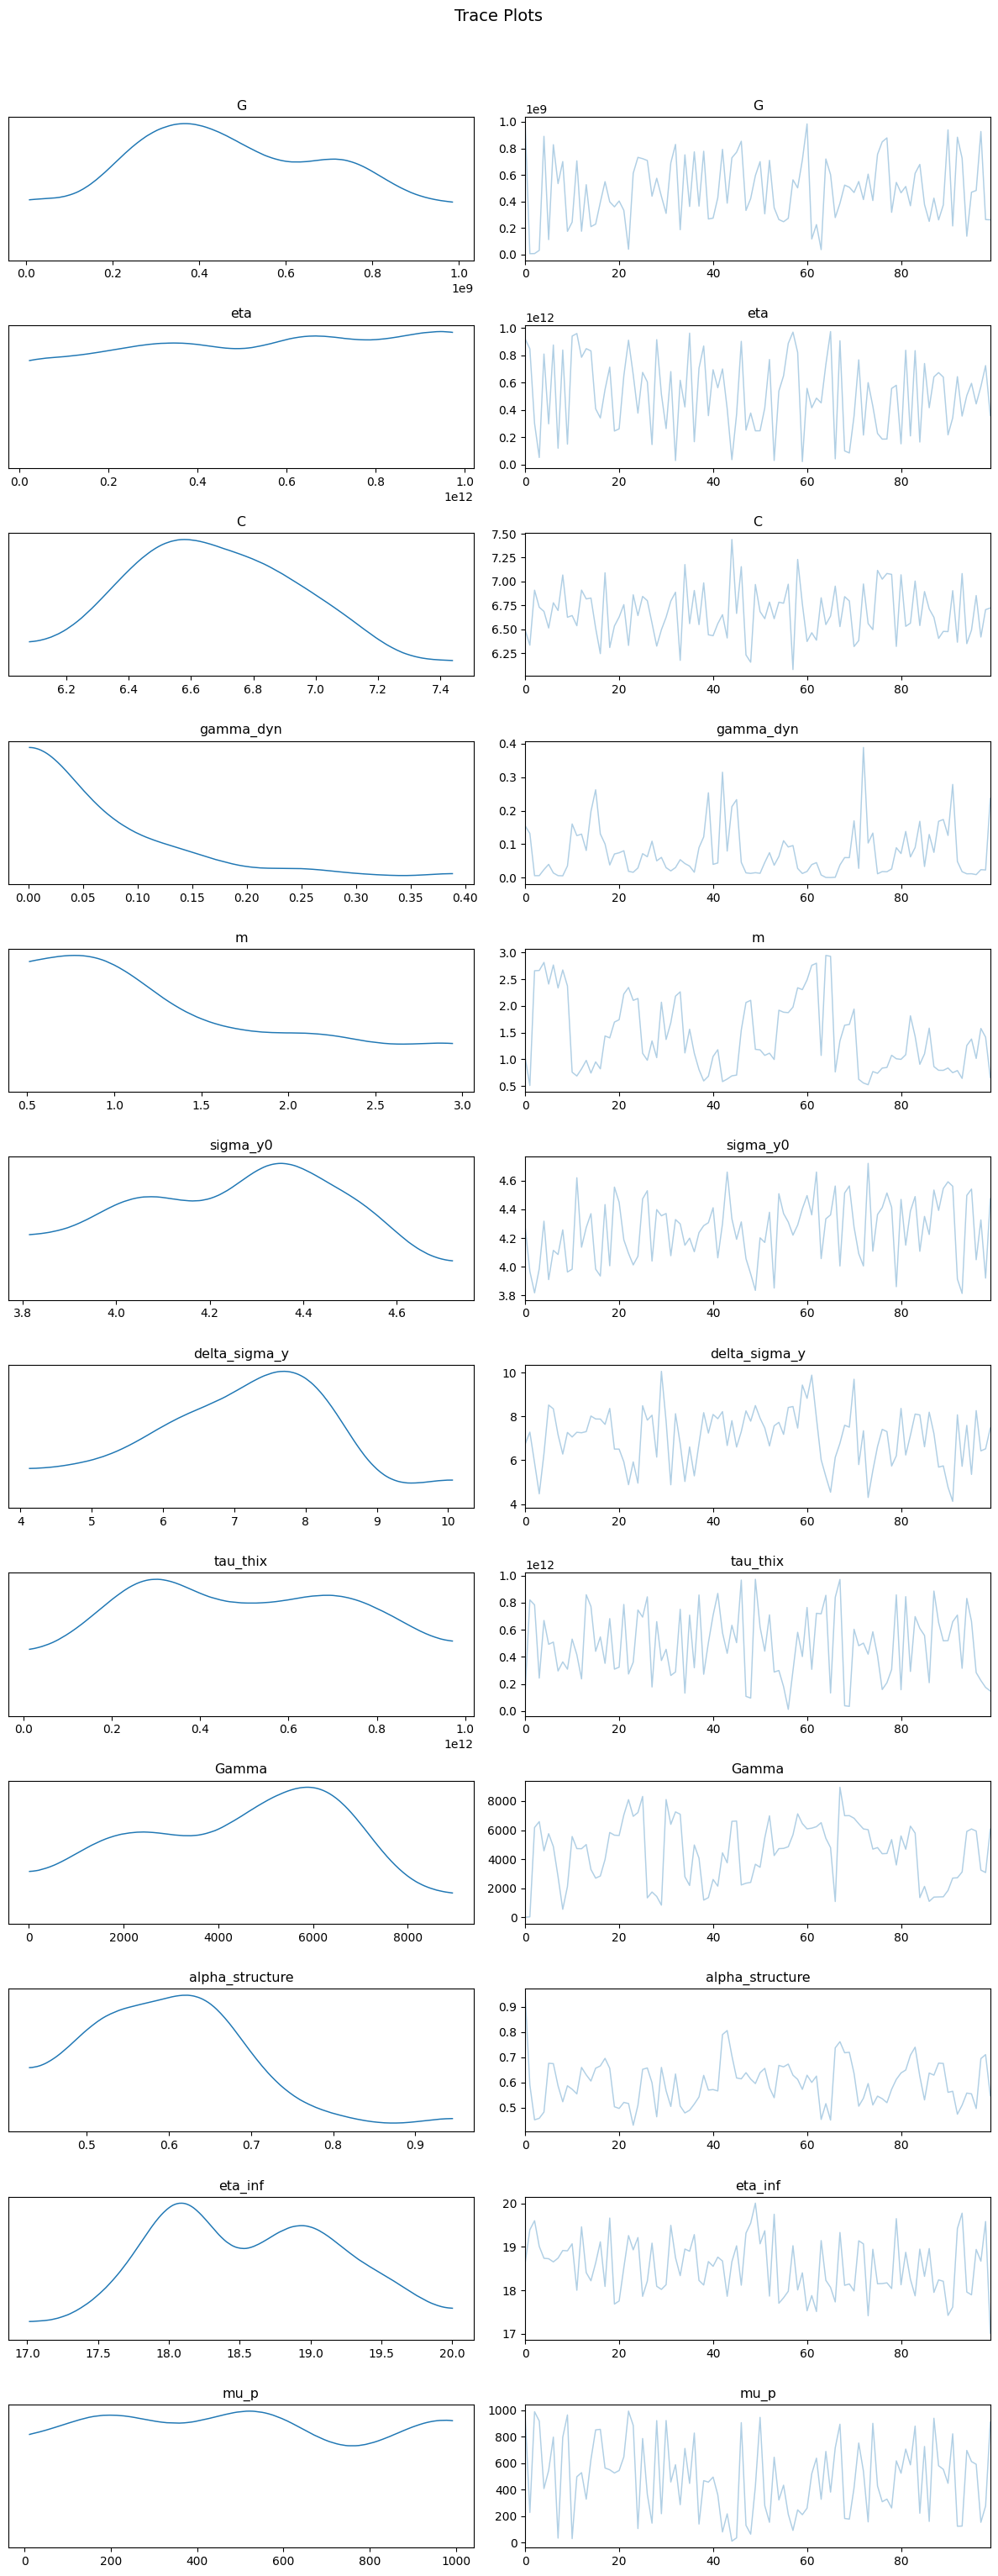

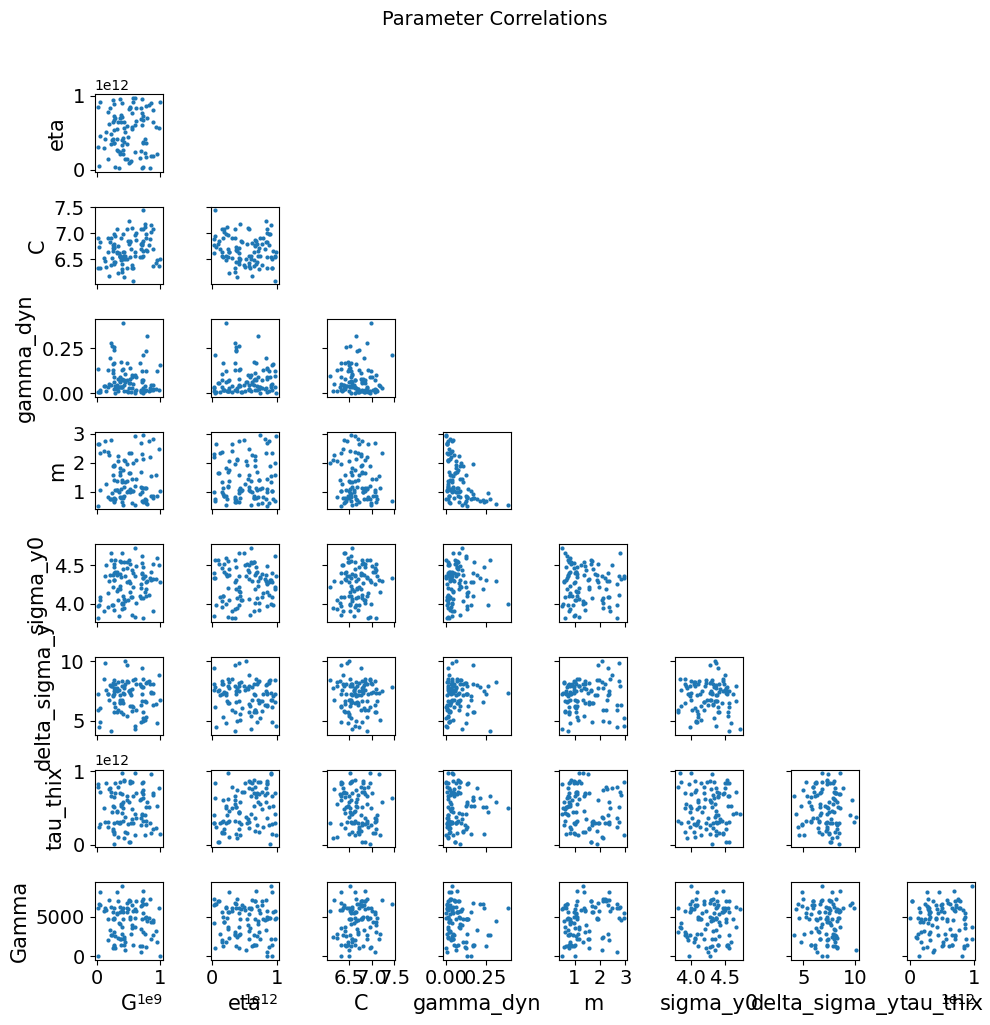

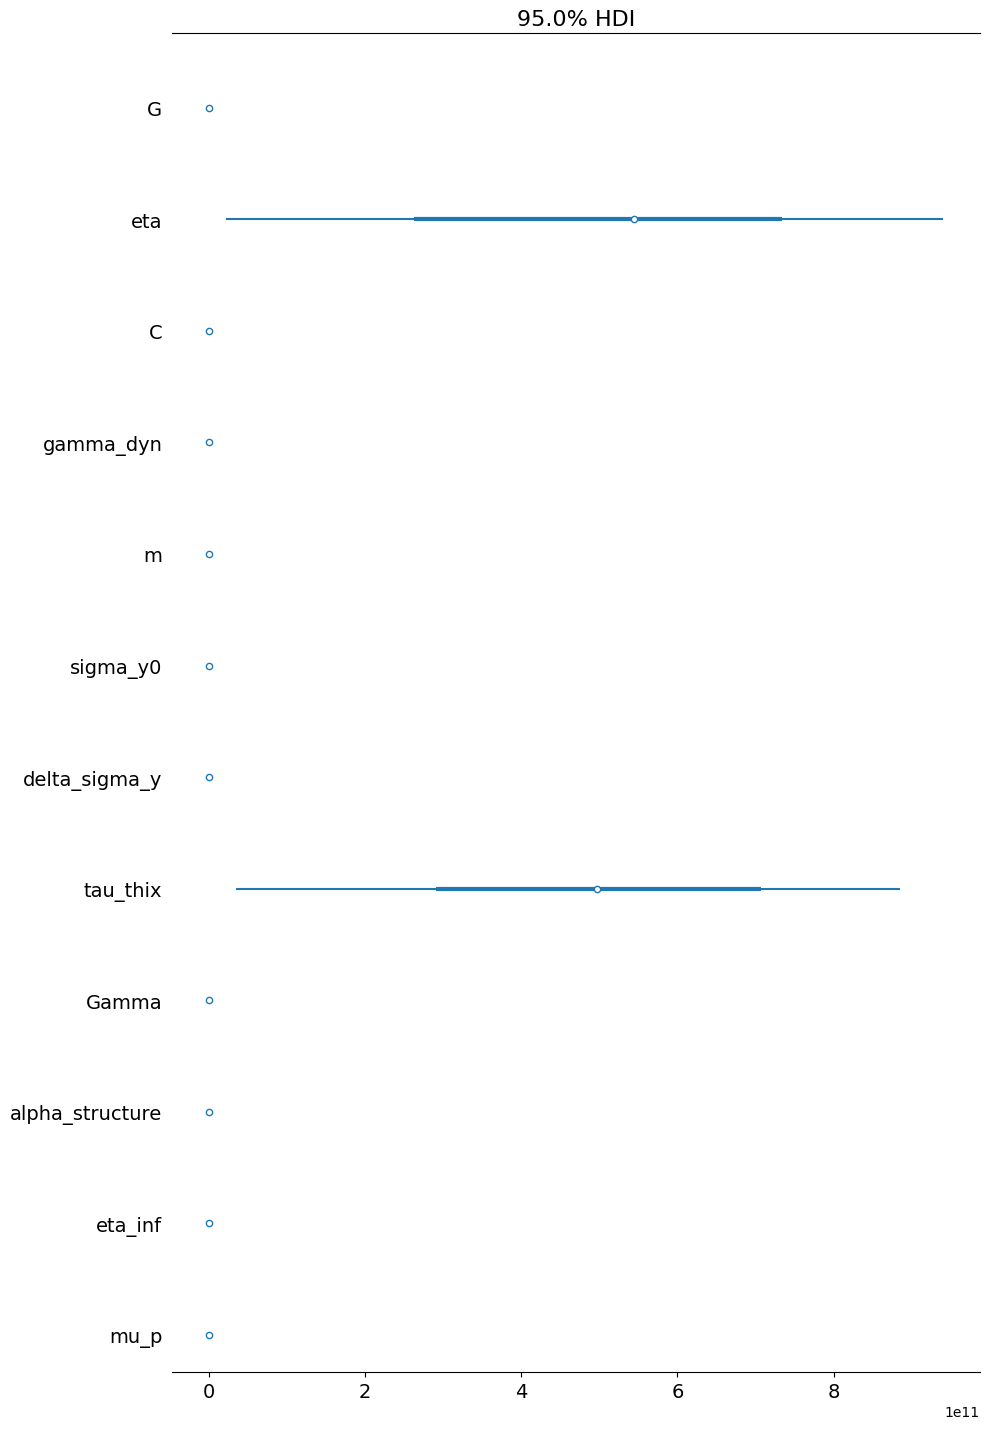

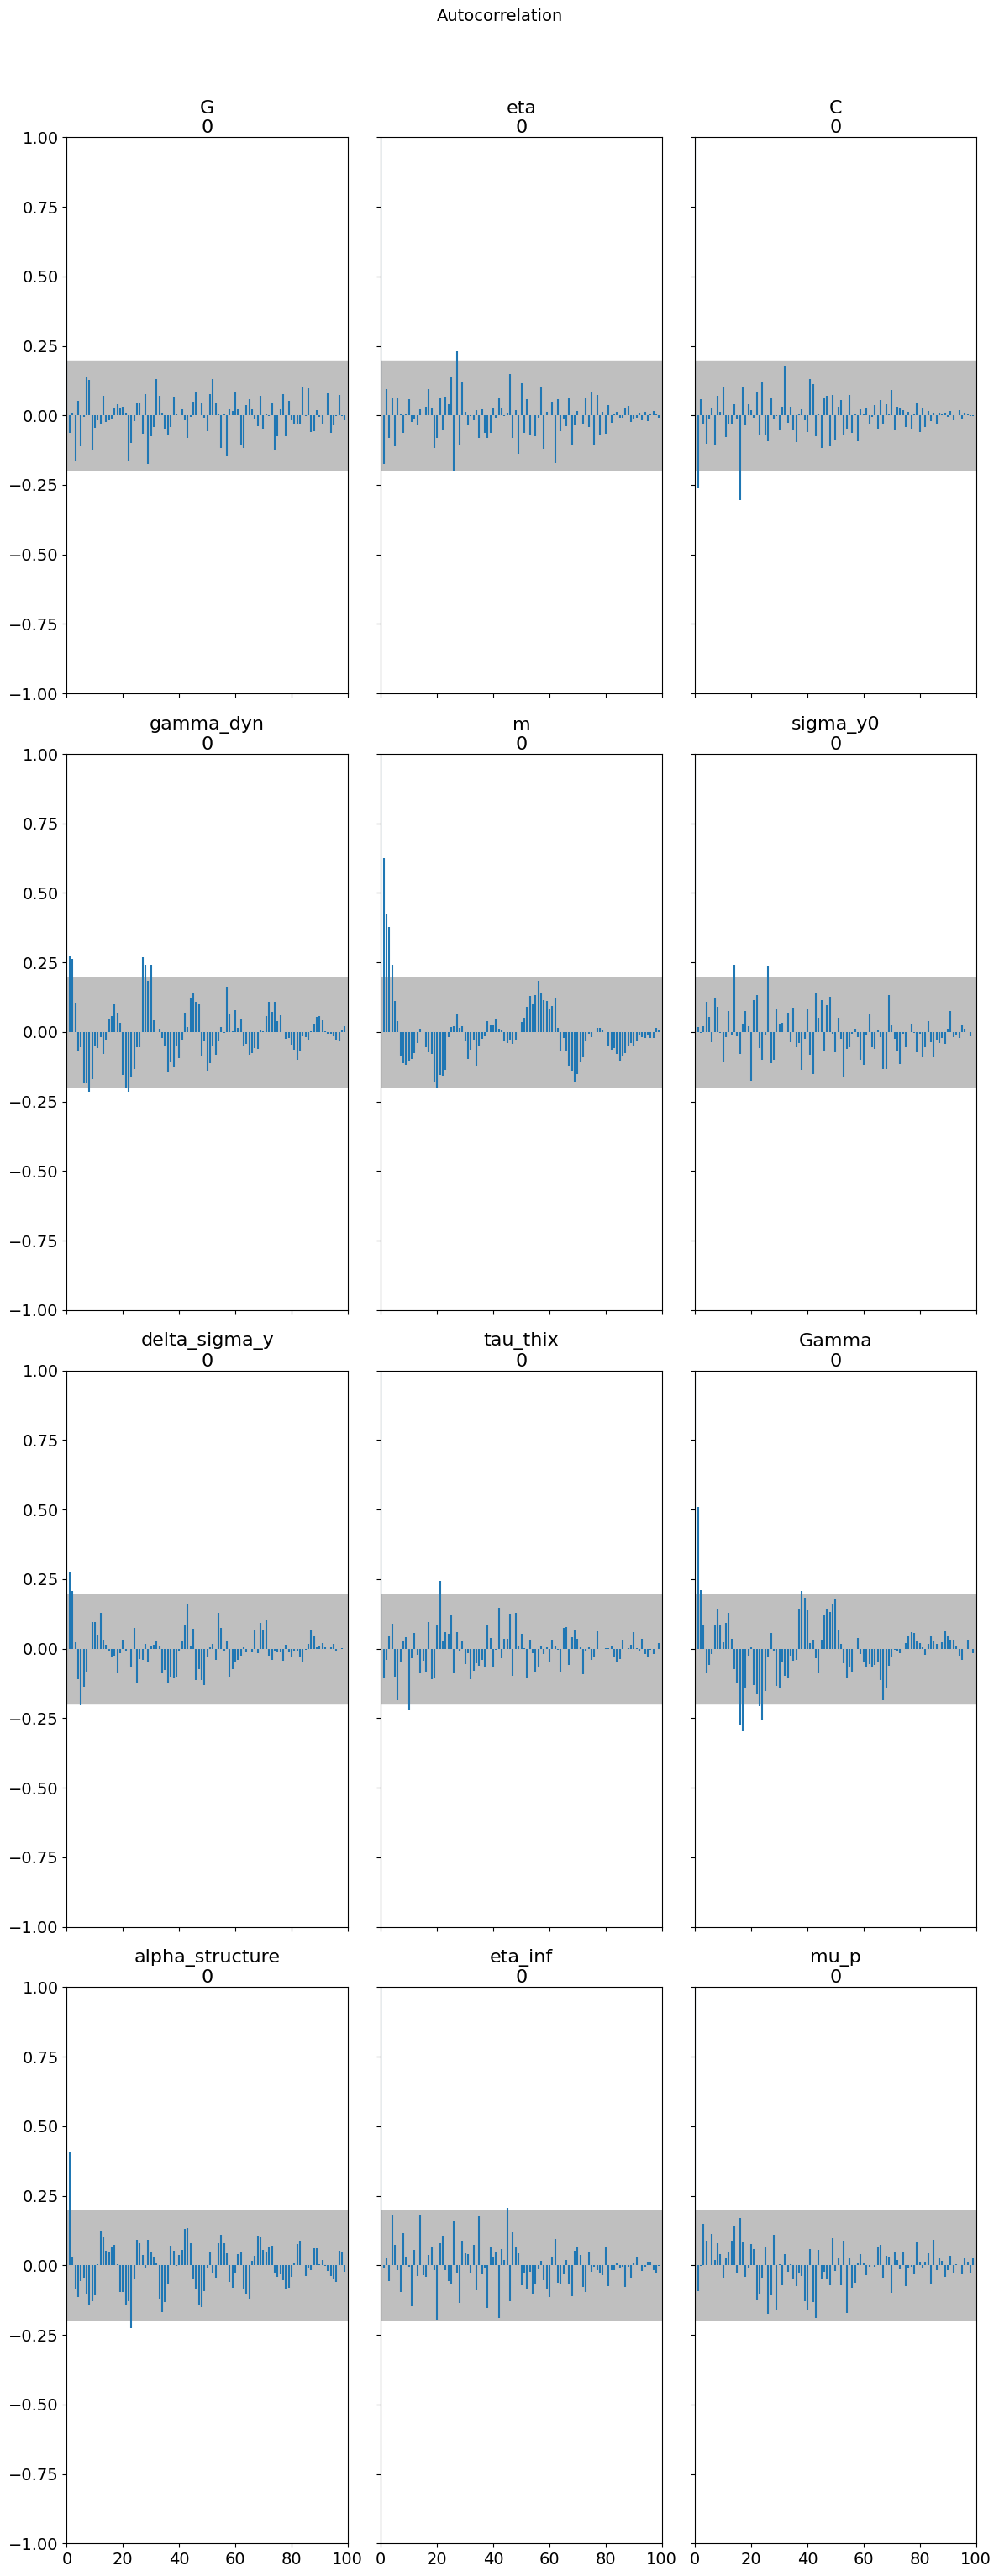

In [12]:
# Convergence and ArviZ diagnostics
all_pass = print_convergence_summary(result, param_names)

print("\n### Diagnostic Targets")
print("| Metric | Target | Interpretation |")
print("|--------|--------|----------------|")
print("| **R-hat** | < 1.01 | Chain convergence (< 1.05 acceptable) |")
print("| **ESS** | > 400 | Effective sample size (> 100 min) |")
print("| **Divergences** | < 1% | NUTS sampling quality |")

display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

### Convergence Diagnostics

**Diagnostic Targets:**

| Metric | Target | Interpretation |
|--------|--------|----------------|
| **R-hat** | < 1.01 | Chain convergence (< 1.05 acceptable) |
| **ESS** | > 400 | Effective sample size (> 100 min) |
| **Divergences** | < 1% | NUTS sampling quality |

In [13]:
# Parameter comparison
posterior = result.posterior_samples
print_parameter_comparison(model, posterior, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G         51.66     4.528e+08  [3.481e+07, 9.331e+08]
            eta     3.618e+07     5.439e+11  [3.371e+10, 9.605e+11]
              C         9.074         6.645  [6.205, 7.167]
      gamma_dyn         1.596       0.04952  [0.003414, 0.2709]
              m         2.234         1.179  [0.5696, 2.807]
       sigma_y0         2.221         4.294  [3.842, 4.641]
  delta_sigma_y          22.3         7.276  [4.501, 9.579]
       tau_thix         14.14     4.971e+11  [6.639e+10, 9.277e+11]
          Gamma         19.97          4739  [690.4, 8105]
alpha_structure        0.8594        0.5966  [0.452, 0.776]
        eta_inf         21.55         18.59  [17.47, 19.71]
           mu_p         0.001         495.6  [34.51, 958.8]


## 8. Save Results

In [14]:
save_fikh_results(model, result, "fikh", "laos", param_names)
print("\nResults saved.")

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fikh/laos/
  nlsq_params_laos.json: 12 parameters
  posterior_laos.json: 100 draws

Results saved.


## Key Takeaways

1. **LAOS combines yielding + oscillation + fractional memory**
2. **Intra-cycle structure evolution** $\lambda(t)$ driven by $D_t^{\alpha} \lambda$
3. **Asymmetric Lissajous figures** from backstress (kinematic hardening)
4. **Higher harmonics decay as $I_n \sim n^{-\alpha}$** (fractional signature)
5. **Delayed intra-cycle yielding** distinguishes FIKH from classical models
6. **Residual analysis** of harmonics validates fractional power-law decay

---

## Further Reading

- **[FIKH LAOS Protocol](../../docs/source/models/fikh/fikh.rst#laos-large-amplitude-oscillatory)**: Harmonic analysis and power-law decay
- **[FIKH Model Overview](../../docs/source/models/fikh/index.rst)**: When to use FIKH vs classical IKH

### Key References

1. Jaishankar, A. & McKinley, G.H. (2014). "A fractional K-BKZ constitutive formulation." *J. Rheol.*, 58, 1751-1788.
2. Dimitriou, C.J. & McKinley, G.H. (2014). "A comprehensive constitutive law for waxy crude oil." *Soft Matter*, 10, 6619-6644.

### Next Steps

**Next**: NB07 (FMLIKH Flow Curve) — multi-mode extension for hierarchical structures